In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import missingno

import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt
%matplotlib inline 
 
warnings.filterwarnings('ignore')

load_dotenv(verbose=True)

raw_data_dir = os.environ.get("RAW_DATA")

In [3]:
%load_ext watermark
%watermark -n -v -iv -d

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.11.0

pandas    : 1.5.3
missingno : 0.5.2
numpy     : 1.24.2
matplotlib: 3.7.1
seaborn   : 0.12.2



In [4]:
native_df = pd.read_csv(raw_data_dir + '/status.csv')
#station = pd.read_csv(raw_data_dir + '/station.csv')
#weather = pd.read_csv(raw_data_dir + '/weather.csv')

#### データ確認
- 24列で一日のデータ
- 1226399件のデータがある

In [5]:
native_df.head().append(native_df.tail(25))

,id,year,month,day,hour,station_id,bikes_available,predict
0,0,2013,9,1,0,0,11.0,0
1,1,2013,9,1,1,0,11.0,0
2,2,2013,9,1,2,0,11.0,0
3,3,2013,9,1,3,0,11.0,0
4,4,2013,9,1,4,0,11.0,0
1226375,1226375,2015,8,30,23,69,NaN,0
1226376,1226376,2015,8,31,0,69,10.0,0
1226377,1226377,2015,8,31,1,69,10.0,0
1226378,1226378,2015,8,31,2,69,10.0,0
1226379,1226379,2015,8,31,3,69,10.0,0


#### 必要なデータに欠損はない
- bike_availableに欠損があるのは予測対象のデータ
- 予測対象のデータに少し偏在がある気がする

<Axes: >

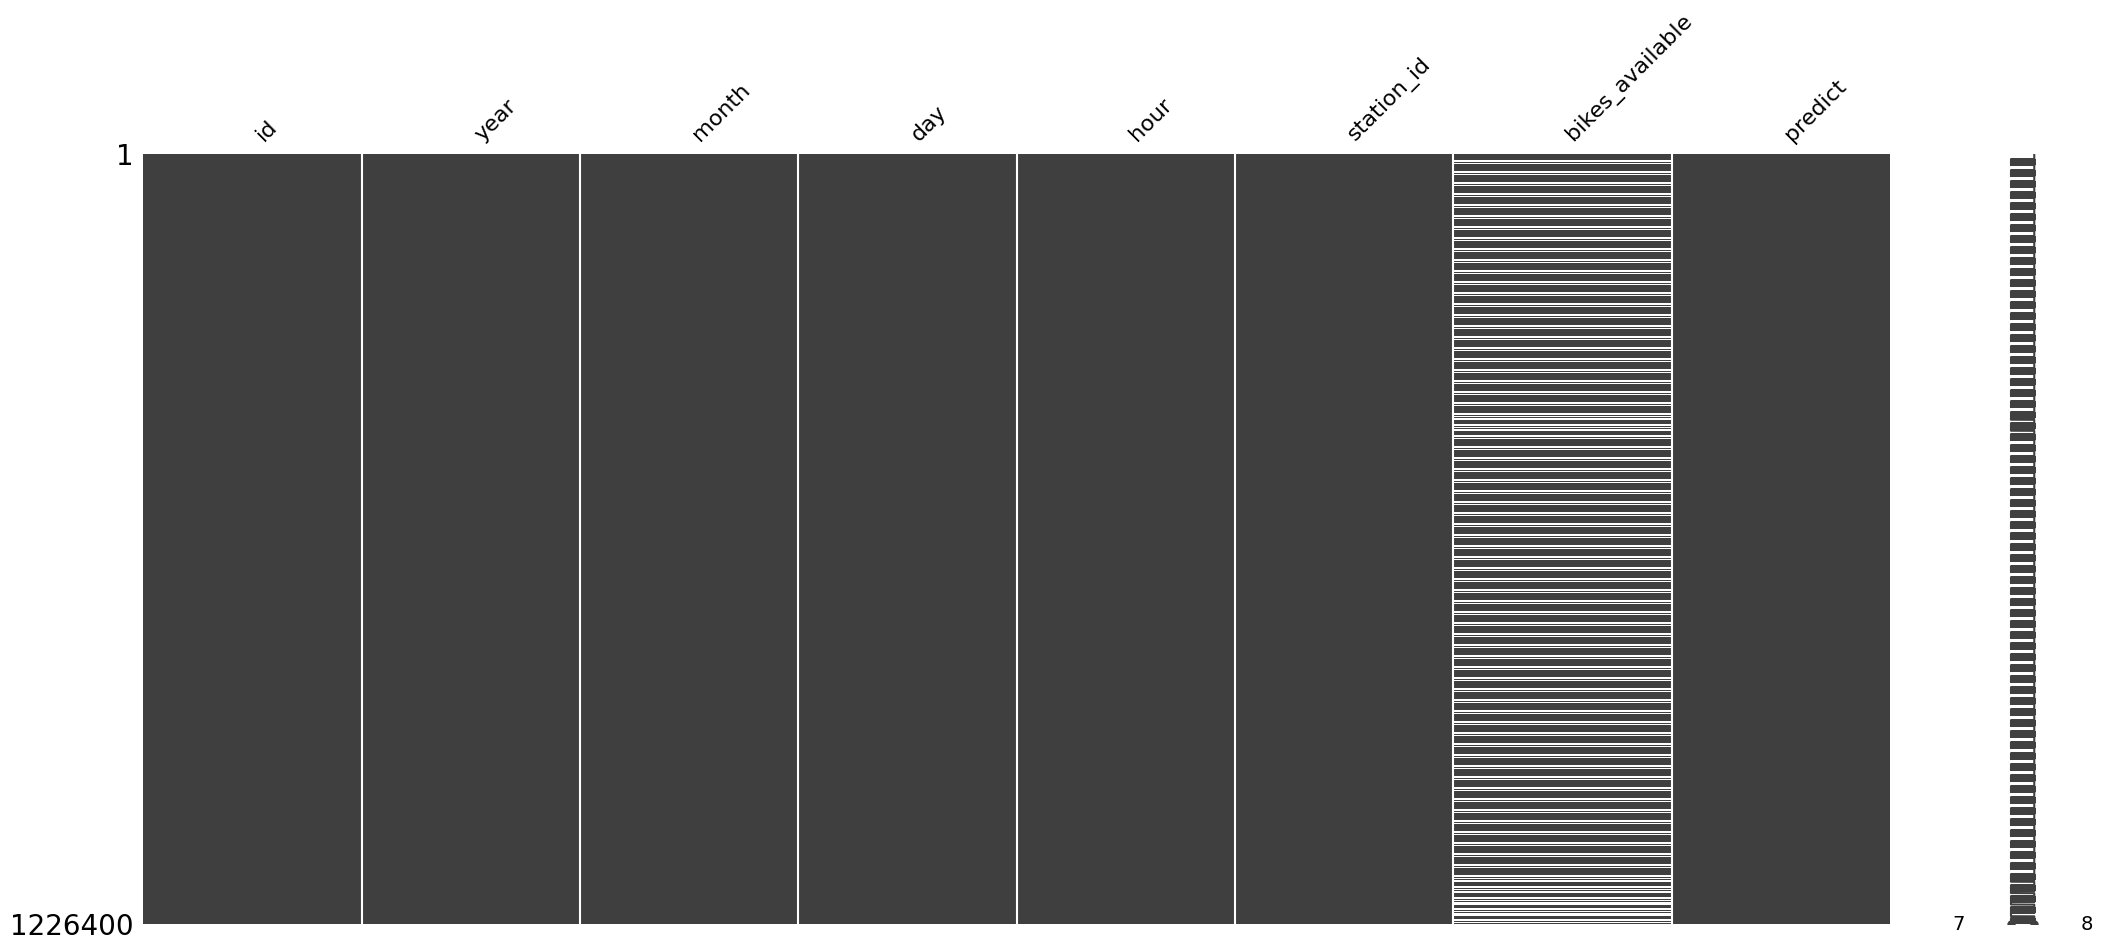

In [6]:
missingno.matrix(native_df)

### 前処理

In [7]:
native_df['datetime'] = pd.to_datetime(native_df[['year', 'month', 'day', 'hour']])
df = native_df.drop(columns=['year', 'month', 'day', 'hour'])

In [8]:
target_df = df[df['predict'] == 1]
train_df = df[df['predict'] == 0]
each_day_df = df.groupby([pd.Grouper(key='datetime', freq='D'), 'station_id'])['predict'].last().reset_index()

In [13]:
each_day_df

,datetime,station_id,predict
0,2013-09-01,0,0
1,2013-09-01,1,0
2,2013-09-01,2,0
3,2013-09-01,3,0
4,2013-09-01,4,0
...,...,...,...
51095,2015-08-31,65,0
51096,2015-08-31,66,0
51097,2015-08-31,67,0
51098,2015-08-31,68,0


## データ量の確認

In [14]:
print(f'ステーションの数は {len(df.station_id.value_counts())} 箇所\n')

print(f'''それぞれのステーションのデータの量は予測対象も含め
{df.station_id.value_counts().values}
''')
print(f"合計で {len(df)//24} 日分のデータ")

print(f'各ステーションにつき は {17520//24} 日分のデータ')

ステーションの数は 70 箇所

それぞれのステーションのデータの量は予測対象も含め
[17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520
 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520
 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520
 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520
 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520
 17520 17520 17520 17520 17520 17520 17520 17520 17520 17520]

合計で 51100 日分のデータ
各ステーションにつき は 730 日分のデータ


### 予測対象のデータ量を確認する

In [15]:
print(f"予測データは {len(target_df)} 件")
print("{:.00%}".format(len(target_df) / len(df)))
print(f"{len(target_df)//23} 日分のデータ")
print(f'''それぞれのステーションの予測対象の量は
{target_df.station_id.value_counts().values}
''')

print(f'各ステーションにつき  {2760//24} 日分のデータ')

予測データは 193200 件
16%
8400 日分のデータ
それぞれのステーションの予測対象の量は
[2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760
 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760
 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760
 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760
 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760 2760]

各ステーションにつき  115 日分のデータ


### 学習対象のデータ量を確認する

In [16]:
print(f'ステーションの数は {len(train_df.station_id.value_counts())} 箇所\n')

print(f'''それぞれのステーションのデータの量は予測対象も含め
{train_df.station_id.value_counts().values}
''')

print(f'各ステーションにつき {14760//24} 日分のデータ')

ステーションの数は 70 箇所

それぞれのステーションのデータの量は予測対象も含め
[14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760
 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760
 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760
 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760
 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760
 14760 14760 14760 14760 14760 14760 14760 14760 14760 14760]

各ステーションにつき 615 日分のデータ


## データ範囲について

- 学習データは2013年9月から2015年8月31日まで
- 出題期間のデータは2014年9月から2015年8月29まで
- 学習データの期間が一年間長い。よって一年分のデータから学習させるとリークがなく、簡単にモデルが作れる、とはいえ、コロナの影響やトレンドの変化などがあるため、直近のデータしか使いものにならない気がする

In [19]:
print(f"全体データの期間は <{df.datetime.min()}> から <{df.datetime.max()}>")
print(f"予測データの期間は <{target_df.datetime.min()}> から <{target_df.datetime.max()}>")

全体データの期間は <2013-09-01 00:00:00> から <2015-08-31 23:00:00>
予測データの期間は <2014-09-01 01:00:00> から <2015-08-29 23:00:00>
